In [1]:
import random
import warnings
from copy import deepcopy

import torch
from cifar_utils import get_dataloader, plot_dataset, plot_history, torch_inference, train
from modell import Fp32VGG19

warnings.filterwarnings("ignore")

In [2]:
dataset_name = "CIFAR_10"

device = "cuda" if torch.cuda.is_available() else "cpu"

param_c10 = {
    "output_size": 10,
    "batch_size": 128,
    "training": "fp32",
    "dataset_name": "CIFAR_10",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_10",
    "seed": 727,
}
param_c100 = {
    "output_size": 100,
    "batch_size": 128,
    "training": "fp32",
    "dataset_name": "CIFAR_100",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_100",
    "seed": 727,
}

# In this tutorial, we present the results of CIFAR-100.
if dataset_name == "CIFAR_100":
    param = param_c100
else:
    # If you want to use it for CIFAR-10, set `dataset_name` to "CIFAR_100"
    param = param_c10

print(f"Device Type: {device}")

Device Type: cuda


100%|██████████| 170498071/170498071 [04:50<00:00, 587198.48it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


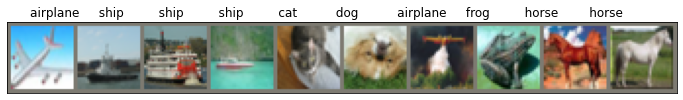

In [3]:
# Load CIFAR-100 or CIFAR-10 data-set according to `dataset_name`.
train_loader, test_loader = get_dataloader(param=param)

# Let’s visualize `n` images from CIFAR data-set.
plot_dataset(test_loader, param)

In [4]:
torch.manual_seed(param["seed"])
random.seed(param["seed"])

# Instantiation of the custom VGG-11 network.
fp32_vgg = Fp32VGG19(param["output_size"]).to(device)

# Loading the pre-trained VGG-11 weights from torch.hub.
pretrained_weights = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "vgg19",
    pretrained=True,
).state_dict()

# Caution:
# The `fp32_vgg.state_dict()` respects the same schema for the convolutional, ReLU and pooling
# layers (order/shape/naming) as the `pretrained_weights` dict, that's why it doesn't throw an error
fp32_vgg.load_state_dict(deepcopy(pretrained_weights), strict=False)
# We got an IncompatibleKeys warning because
# we deleted the classification layers of the original VGG-19 network.

Using cache found in /user/HS401/kp01235/.cache/torch/hub/pytorch_vision_v0.10.0


_IncompatibleKeys(missing_keys=['final_layer.weight', 'final_layer.bias'], unexpected_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [5]:
# We freeze all the layers.
for p in list(fp32_vgg.parameters()):
    p.requires_grad = False

# Set the `requires_grad` of the last layer at `True` to fine-tune it.
fp32_vgg.final_layer.weight.requires_grad = True
fp32_vgg.final_layer.bias.requires_grad = True

In [6]:
if dataset_name == "CIFAR_100":
    param["lr"] = 0.06
    param["epochs"] = 10
    param["gamma"] = 0.01
    param["milestones"] = [1]
elif dataset_name == "CIFAR_10":
    param["lr"] = 0.1
    param["epochs"] = 5
    param["gamma"] = 0.1
    param["milestones"] = [1, 3]

fp32_vgg = train(fp32_vgg, train_loader, test_loader, param, device=device)


Epoch  0: Train loss = 1.4606 VS Test loss = 1.3218 - Accuracy train: 0.4998 VS Accuracy test: 0.5584
Epoch  1: Train loss = 1.2386 VS Test loss = 1.1485 - Accuracy train: 0.5655 VS Accuracy test: 0.6028
Epoch  2: Train loss = 1.2104 VS Test loss = 1.1345 - Accuracy train: 0.5740 VS Accuracy test: 0.6084
Epoch  3: Train loss = 1.1833 VS Test loss = 1.1283 - Accuracy train: 0.5807 VS Accuracy test: 0.6115
Epoch  4: Train loss = 1.1808 VS Test loss = 1.1289 - Accuracy train: 0.5835 VS Accuracy test: 0.6112
100%|██████████| 5/5 [06:32<00:00, 78.41s/it]


In [7]:
# Secondly, fine-tuning all the layers.
for p in list(fp32_vgg.parameters()):
    p.requires_grad = True

if dataset_name == "CIFAR_100":
    param["lr"] = 0.0006
    param["epochs"] = 7
    param["gamma"] = 0.1
    param["milestones"] = [6]

elif dataset_name == "CIFAR_10":
    param["lr"] = 0.0006
    param["epochs"] = 5
    param["gamma"] = 0.1
    param["milestones"] = [4]

fp32_vgg = train(fp32_vgg, train_loader, test_loader, param, device=device)
     

Epoch  0: Train loss = 1.7423 VS Test loss = 1.0672 - Accuracy train: 0.3608 VS Accuracy test: 0.6085
Epoch  1: Train loss = 0.9456 VS Test loss = 0.7129 - Accuracy train: 0.6709 VS Accuracy test: 0.7594
Epoch  2: Train loss = 0.6884 VS Test loss = 0.5697 - Accuracy train: 0.7685 VS Accuracy test: 0.8143
Epoch  3: Train loss = 0.5812 VS Test loss = 0.5933 - Accuracy train: 0.8079 VS Accuracy test: 0.8088
Epoch  4: Train loss = 0.3766 VS Test loss = 0.4038 - Accuracy train: 0.8745 VS Accuracy test: 0.8670
100%|██████████| 5/5 [08:17<00:00, 99.46s/it]


In [8]:
acc = torch_inference(fp32_vgg, data=test_loader, device=device)
print(f"With {dataset_name}: top-1 accuracy = {acc * 100:2.3f}%")

With CIFAR_10: top-1 accuracy = 86.709%


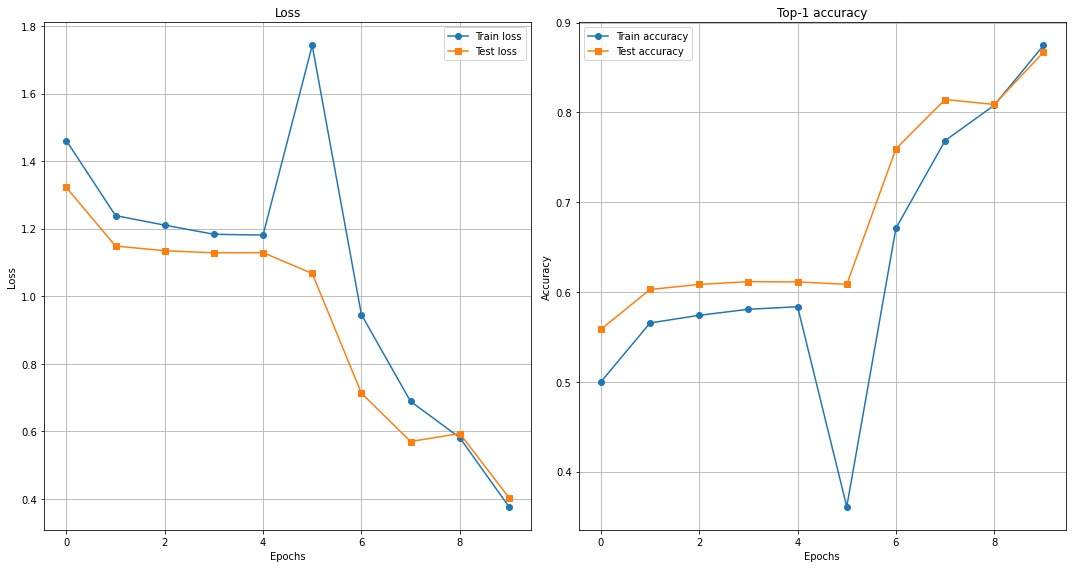

In [9]:
plot_history(param)

In [10]:
torch.save(fp32_vgg.state_dict(), f"{param['dir']}/{param['dataset_name']}_fp32_state_dict.pt")


In [11]:
print(param['dir'])

./checkpoints/CIFAR_10


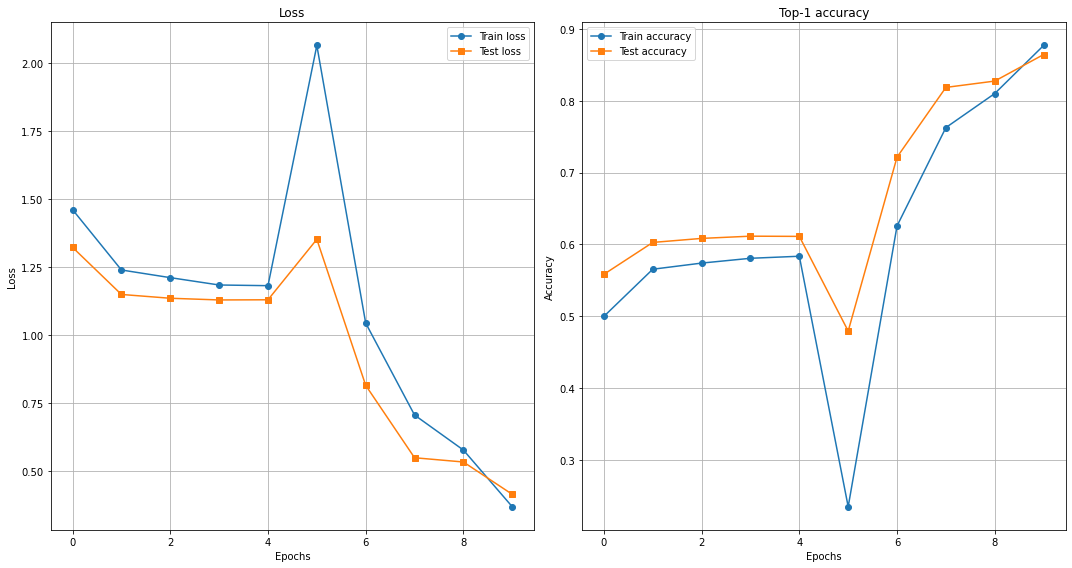

In [22]:
plot_history(param_c10, load=True)